## Importing Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy import signal
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

## Loading Images

In [4]:
source_img = cv.imread('res05.jpg')
dest_img = cv.imread('res06.jpg')

In [5]:
print(source_img.shape, dest_img.shape)

(450, 600, 3) (450, 600, 3)


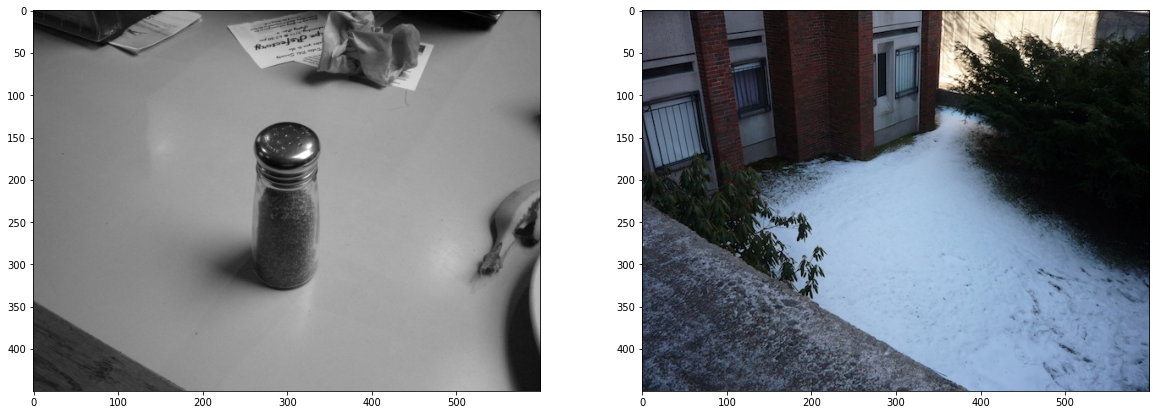

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv.cvtColor(source_img, cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(dest_img, cv.COLOR_BGR2RGB));

## Creating Masks

#### Source Mask

We want to crop the object from the left image (source image) to the right image (destination image). For selecting the area of the object in the left image, you can uncomment the code block and click (left click) on the start points of your curve. Then move your mouse to draw your desired curve and when you are finished (the curve is fully connected and the start and end point are the same) you should click again (left click). You can also use the `q2-source_mask.npy` for your source mask.

In [7]:
def get_points(source_img):    
    def draw_circle(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN or (event == cv.EVENT_MOUSEMOVE and len(coords) > 0):
            if event == cv.EVENT_LBUTTONDOWN and len(coords) > 0: # Second click
                cv.destroyAllWindows()
            coords.append([x, y])
            cv.circle(img, (x, y), 1, (0, 0, 255), -1)
            cv.imshow('image', img)

    coords = []
    img = source_img.copy()
    cv.namedWindow('image')
    cv.setMouseCallback('image', draw_circle)
    cv.imshow('image', img)
    cv.waitKey(0)
    cv.destroyAllWindows()

    return np.array(coords)

In [25]:
# coords = get_points(source_img)
# source_mask = cv.fillPoly(
#     np.zeros(source_img.shape[:2]),
#     [coords],
#     (255, 255, 255)
# ).astype(bool)
# np.save("q2-source_mask.npy", source_mask)

In [24]:
source_mask = np.load('q2-source_mask.npy')

You can see the binary mask result below

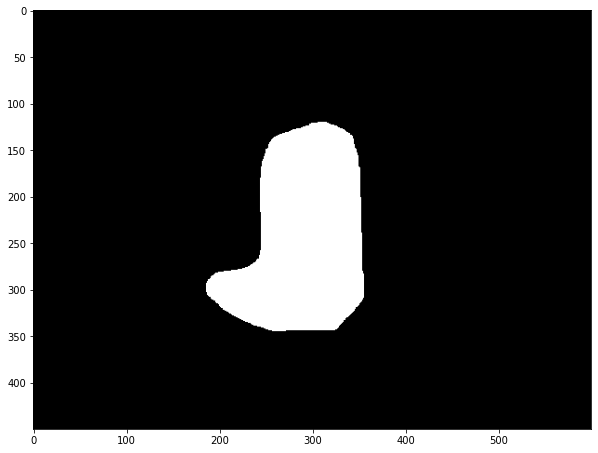

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(source_mask, cmap='gray');

#### Destination Mask

Now that we have the source mask, we need to place it somewhere in the destination image which we call destination mask. You can use `q2-dest_mask.npy` (if you've decided to use `q2-source_mask.npy` in the previous step). For doing this by yourself, uncomment the code block and run it. Click somewhere the image and the object will be shown for you and you can choose where to put it. When you finally decided where the object suits the best, just press `ESC` button to quit. Note that the point that you're clicking and the object apears, is the center of the object. Also keep in mind that clicking too far on the right of the image or too far on the bottom of the image will result in error, but, you can continue clicking somewhwere else in order to find another place for it.

In [27]:
def get_dest_mask(dest_img, source_img, source_mask):    
    def draw_circle(event, x, y, flags, param):
        global new_dest_points
        if event == cv.EVENT_LBUTTONDOWN:
            diff = np.array([y, x]) - source_mean_points
            new_dest_points = (source_points + diff).astype(np.int16).T
            img = dest_img.copy()
            img[new_dest_points[0], new_dest_points[1]] = source_img[source_mask]
            cv.imshow('image', img)

    source_points = np.array(np.where(source_mask)).T
    source_mean_points = source_points.mean(axis=0)
    
    img = dest_img.copy()
    cv.namedWindow('image')
    cv.setMouseCallback('image', draw_circle)
    cv.imshow('image', img)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    dest_mask = np.zeros_like(source_mask)
    dest_mask[new_dest_points[0], new_dest_points[1]] = True

    return dest_mask

In [29]:
# dest_mask = get_dest_mask(dest_img, source_img, source_mask)
# np.save("q2-dest_mask.npy", dest_mask)

In [30]:
dest_mask = np.load("q2-dest_mask.npy")

You can see the destination mask as well as the object in the destination image (using the destination mask and source mask) below

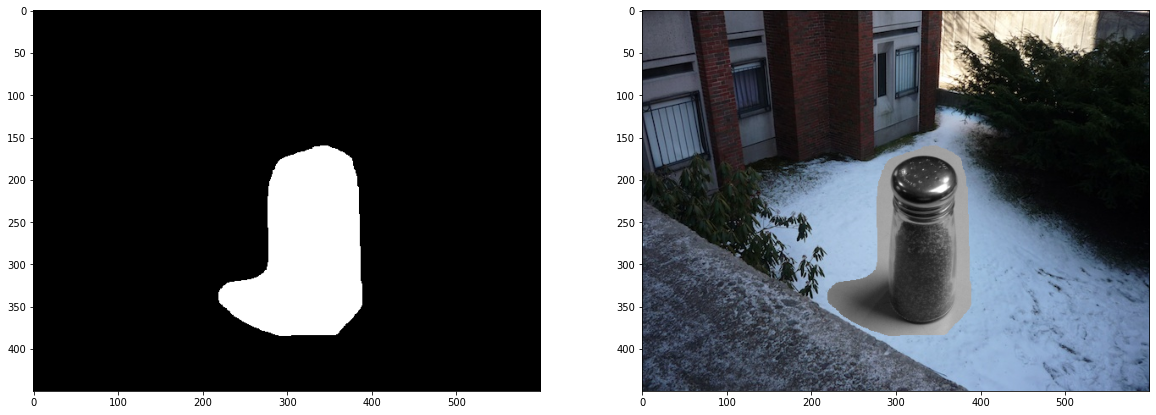

In [32]:
tmp_dest = dest_img.copy()
tmp_dest[dest_mask] = source_img[source_mask]

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(dest_mask, cmap='gray')
axs[1].imshow(cv.cvtColor(tmp_dest, cv.COLOR_BGR2RGB));

## Crop and Paste

You can see below that if we just simply cropped the object from the source image and pasted in into the destination image, we would get something that is not really desired

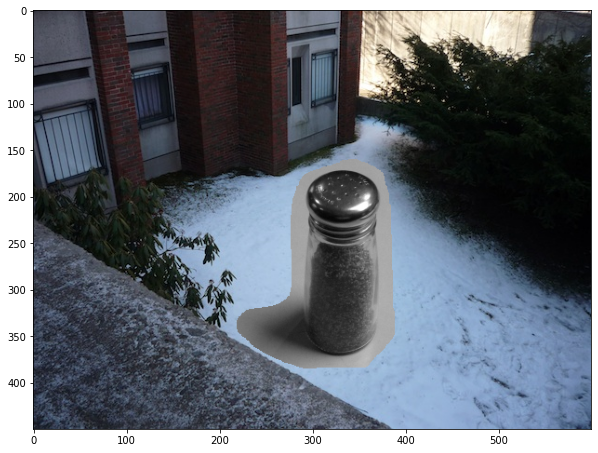

In [34]:
tmp = dest_img.copy()
tmp[dest_mask] = source_img[source_mask]

plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(tmp, cv.COLOR_BGR2RGB), cmap='gray');

## Poisson Blending

In this method, our objective is to take an object from a source image and blend it in a destination image. The main idea is to preserve the gradients of the source image and use the colors of the destination image in the boundries of the shape and calculate the pixels inside the shape using these two (more details in the following). The reason behind this is that, generally, the gradients of the image is the main reason that we can detect the objects in it and our visual system is more sensitive to local contrasts than absolute intensities in each area (like the example of bright circles in dark surroundings)

Some notations:
- $g$: Source image
- $s$: Destination image
- $\Omega$: Area of the destination image that we want to put the object in from source image
- $\partial \Omega$: Boundries of $\Omega$
- $f$: Function that puts area of source image in $\Omega$
- $f^*$: Function that fills the rest of the pixels of $\Omega$

If we write down our objective:

$min \iint_\Omega |\nabla f - \nabla g|^2 \;\;\;\;\; s.t. \;\;\;\;\; \forall (x, y) \in \partial \Omega \;\; f(x, y) = f^*(x, y)$

The first part ensures that the graidnets from source image are preserved and the first part is to take the colors from destination image for the boundries.

Using Poisson's theorem and apply it to the objectective that we mentioned we get:

$\Delta f = div \nabla g \;\; over \;\; \Omega \;\;\;\;\; s.t. \;\;\;\;\; \forall (x, y) \in \partial \Omega \;\; f(x, y) = f^*(x, y)$

And using the fact that $div \nabla g$ equals to $\Delta g$:
$$
\begin{cases} 
   \Delta f = \Delta g & (x, y) \in \Omega \\
   f(x, y) = f^*(x, y) = s(x, y)       & (x, y) \in \partial \Omega
\end{cases}
$$

And wwe can estimate $\Delta g$ by writing down the taylor series for $g(x+1, y)$, $g(x-1, y)$, $g(x, y+1)$ and $g(x, y-1)$:

$\Delta g(x, y) = g(x+1, y) + g(x-1, y) + g(x, y+1) + g(x, y-1) - 4g(x, y)$

Now, we can construct $N$ equations with $N$ unknowns and solve it.


---

Lets find the boundries of the mask first. a point is not on the boundry of the mask iff it's top, left, right and bottom neighbors are inside the mask. Using this fact, we apply a filter on our mask and retrieve the boundries.

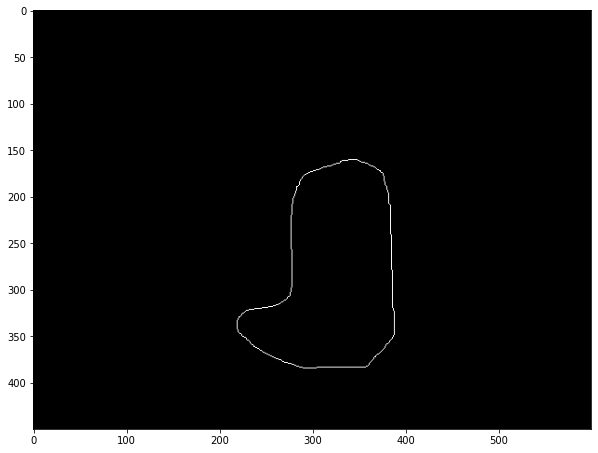

In [35]:
filter = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])
mask_non_boundries = signal.convolve2d(dest_mask.astype(np.int16), filter, mode='same') == 5
mask_boundries = dest_mask & ~mask_non_boundries

plt.figure(figsize=(10, 10))
plt.imshow(mask_boundries, cmap='gray');

In order to build our $N$ euqations with $N$ unknowns, we need to assign a variable $idx$ to each pixel $(x, y)$. Here, we just make these mappings

In [36]:
source_dest_diff_vector = np.array(np.where(source_mask)).T[0] - np.array(np.where(dest_mask)).T[0]

# idx -> (i, j)
dest_mask_idx = np.array(np.where(dest_mask)).T
source_mask_idx = dest_mask_idx + source_dest_diff_vector

# (i, j) -> idx
dest_mask_idx_rev = {}
for idx, (i, j) in enumerate(dest_mask_idx):
    dest_mask_idx_rev[str([i, j])] = idx

# idx -> bool
is_boundry = np.zeros(dest_mask_idx.shape[0], dtype=bool)
boundries_points = np.array(np.where(mask_boundries)).T
for idx, (i, j) in enumerate(dest_mask_idx):
    if np.all(boundries_points == [[i, j]], axis=1).any():
        is_boundry[idx] = True

for calculating the $\Delta g$ we just simply convolve the below filter on our source image.

In [37]:
laplacian_filter = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
])
source_laplacian = np.stack([signal.convolve2d(source_img[:, :, ch].astype(np.float32), laplacian_filter, mode='same') for ch in range(3)], axis=2)

Now, it's time to make our equations. using the below formula:
$$
\begin{cases} 
   \Delta f = \Delta g & (x, y) \in \Omega \\
   f(x, y) = f^*(x, y) = s(x, y)       & (x, y) \in \partial \Omega
\end{cases}
$$

**Note**: We incur a very sparse matrix for our equations, each row consist either a single value $1$ or $5$ values (four $-1$ and one $4$) and the rest is $0$. So it's better to not to create the whole matrix, but, to create in form of CSR_Matrix and then solve it using `scipy.sparse.linalg.spsolve`.

In [38]:
N = dest_mask_idx.shape[0]

result = dest_img.copy().astype(np.float32)

for channel in range(3):
    row, col, data, b = [], [], [], []
    for idx in range(N):
        if is_boundry[idx]:
            row.append(idx)
            col.append(idx)
            data.append(1)
            dest_coord = dest_mask_idx[idx]
            dest_value = dest_img[dest_coord[0], dest_coord[1], channel]
            b.append(dest_value)
        else:
            row.extend([idx for _ in range(5)])
            
            dest_coord = dest_mask_idx[idx]
            neighbors_coord = [
                [dest_coord[0]+1, dest_coord[1]],
                [dest_coord[0]-1, dest_coord[1]],
                [dest_coord[0], dest_coord[1]+1],
                [dest_coord[0], dest_coord[1]-1]
            ]
            neighbors_idx = [dest_mask_idx_rev[str(coord)] for coord in neighbors_coord]
            col.extend([n_idx for n_idx in neighbors_idx] + [idx])
            
            data.extend([-1, -1, -1, -1, 4])
            
            b.append(source_laplacian[source_mask_idx[idx][0], source_mask_idx[idx][1], channel])

    A = csr_matrix((data, (row, col)), shape=(N, N))
    x = spsolve(A, b)
    for idx, dest_val in enumerate(x):
        dest_coord = dest_mask_idx[idx]
        result[dest_coord[0], dest_coord[1], channel] = dest_val

Now we just clip the values to range $(0, 255)$ and convert it's type to `np.uint8`

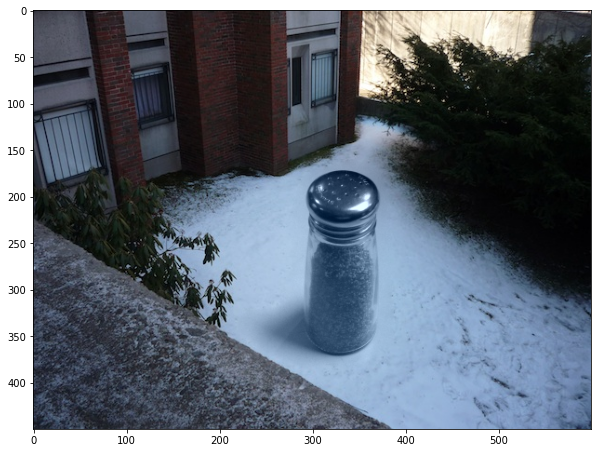

In [40]:
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(result.clip(0, 255).astype(np.uint8), cv.COLOR_BGR2RGB));